## Erdos Project - CAFA5
### AIM: Produce notebook that takes the T5 embeddings and uses a simple neural net to generate predictions of protein function.

30 May 2023

References:

https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary#Prepare-Train-Test-split

https://www.kaggle.com/code/gusthema/cafa-5-protein-function-with-tensorflow

## Notebook Outline

The embedding encodes information about the relationships between proteins based upon their sequences (no human labeling was involved in the generation of the embeddings). The T5 embedding contains 1024 numerical features for each of 142246 proteins, whereas the original set of protein sequences contains sequential categorical data (amino acid chains) of varying lengths (100s to 1000s).

### Steps
0. Import packages and load input data.

1. Load the training data from the CAFA5 dataset (train_terms.tsv). Convert these data to a multi-one-hot encoded Labels array ("Y"), using the protein instances from the T5 embedding (rows = protein instances; columns = functional labels).

2. Load the T5 embedding (t5embeds/train_embeds.npy) as features ("X").

3. Run a neural network model trained on the features (X) and labels (Y).



# 0. Import packages and input data 

In [1]:
# install tf-nightly in order to use F1-score metric
!pip install tf-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # neural net modeling
import seaborn as sns # pretty graphing
import matplotlib.pyplot as plt # graphing
import progressbar # Required for progressbar widget

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
print("TensorFlow v" + tf.__version__)
print("Numpy v" + np.__version__)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2023-06-01 01:54:07.344560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-01 01:54:07.344637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-01 01:54:07.344658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo
TensorFlow v2.14.0-dev20230531
Numpy v1.23.5


In [3]:
n_labels_to_consider = 1499 # We will choose only top frequent labels (in train) and predict only them. 

# 1. Load training data from CAFA5 dataset & convert to Labels array (Y)

### Load CAFA5 training set into a pandas dataframe

In [4]:
%%time
# Measure the execution time of the code block

trainTerms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv", sep="\t")
# Read the contents of the "train_terms.tsv" file into a pandas DataFrame, using '\t' (tab) as the delimiter.
# Assign the resulting DataFrame to the variable 'trainTerms'.

print("Shape of train_terms.tsv dataset: " + str(trainTerms.shape))
# Print the shape of the 'trainTerms' DataFrame, which represents the dimensions (number of rows and columns) of the dataset.

print()
# Print an empty line for better readability.

print("Dataframe from train_terms.tsv dataset:")
display(trainTerms.head(5))
# Display the first 5 rows of the 'trainTerms' DataFrame using the 'head()' function.
# This provides a preview of the data in the DataFrame.

print()

print("Frequency of each term (i.e. label) in train_terms.tsv dataset:")
vec_freqCount = trainTerms['term'].value_counts()
# Compute the frequency count of each unique term (label) in the 'term' column of the 'trainTerms' DataFrame.
# Assign the resulting Series object to the variable 'vec_freqCount'.

print(vec_freqCount)
# Print the frequency count of each term.
# This displays the number of occurrences of each term in the dataset.

print()

labels_to_consider = list(vec_freqCount.index[:n_labels_to_consider])
# Extract the first 'n_labels_to_consider' terms from the index of the 'vec_freqCount' Series.
# Convert the resulting index values (terms) to a list.
# Assign the list of terms to the variable 'labels_to_consider'.

print('n_labels_to_consider:', len(labels_to_consider), 'First 10:', labels_to_consider[:10])
# Print the number of labels to consider ('n_labels_to_consider') and the first 10 labels in the 'labels_to_consider' list.

print()

Shape of train_terms.tsv dataset: (5363863, 3)

Dataframe from train_terms.tsv dataset:


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO



Frequency of each term (i.e. label) in train_terms.tsv dataset:
GO:0005575    92912
GO:0008150    92210
GO:0110165    91286
GO:0003674    78637
GO:0005622    70785
              ...  
GO:0031772        1
GO:0042324        1
GO:0031771        1
GO:0051041        1
GO:0102628        1
Name: term, Length: 31466, dtype: int64

n_labels_to_consider: 1499 First 10: ['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622', 'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227']

CPU times: user 2.37 s, sys: 465 ms, total: 2.83 s
Wall time: 3.76 s


#### Columns of the training set dataframe:
- EntryID = identifier that is unique to each protein (but the same protein will have multiple instances)

- term = identifier that is unique to each protein function label. It is "GO:" followed by a 7-digit number, but each one is a class (i.e. there is not necessarily any algorithmic relationship between consecutively numbered classes).

- aspect = broad categorisation of GO labels (into "BPO", "MFO", CCO", which are the three top-level terms)

The combination of "EntryID" and "term" should constitute a unique entry.

In summary, there are 5.3 million labeled entries in the training dataset, with 31,466 unique labels. The most frequent labels have ~93,000 entries (i.e. proteins), while the least frequent labels have 1 entry (1 protein).

### Load the protein IDs from the T5 embeddings training set
The list of protein IDs in the T5 embeddings training set is used to figure out how many rows we need in the Labels array (Y). We want one row per protein instance.

In [5]:
%%time
# Measure the execution time of the code block

fn = '/kaggle/input/t5embeds/train_ids.npy'
# Set the variable fn to the file path '/kaggle/input/t5embeds/train_ids.npy'
# This indicates the location of a NumPy array file.

vec_train_protein_ids = np.load(fn)
# Load the NumPy array from the file specified by fn and assign it to the variable vec_train_protein_ids
# This reads the array data from the file into memory.

print(vec_train_protein_ids.shape)
# Print the shape of vec_train_protein_ids
# This will output the dimensions of the array, indicating the number of elements in each axis.

vec_train_protein_ids
# Output the vec_train_protein_ids array itself
# This will display the content of the array.

(142246,)
CPU times: user 2.93 ms, sys: 4.16 ms, total: 7.09 ms
Wall time: 46.5 ms


array(['P20536', 'O73864', 'O95231', ..., 'Q5RGB0', 'A0A2R8QMZ5',
       'A0A8I6GHU0'], dtype='<U10')

The T5 embeddings were generated from 142,246 unique proteins.


### Prepare Y (all the labels, in a 2D array)

That is, generate a large array with each row being a unique protein and each column being a unique label, and entries being either "1" to indicate that a particular protein has a particular label and "0" being that it does not (i.e. binary labeling). Multilabel "one"-hot encoding.

The next code block does the following:

1. Make an array (of zeroes) with enough rows for all the proteins with embeddings and columns for all the labels to consider (i.e. the top n most common labels). Call this array "Y".

2. Make a pandas series from all the protein IDs in the T5 dataset (all the proteins that have embeddings).

3. "trainTerms" is the pandas dataframe containing the labeled training data (from CAFA5). Truncate this to only include the top n most common labels => "trainTerms_smaller". Now 4.42 million entries instead of original 5.3 million.

4. for loop: For every column in the Labels array (Y), compare 'term' class from trainTerms_smaller dataframe with the labels_to_consider entries and return True if they are the same (False if not the same); assign True/False to the variable m. For all the rows in that column, look for the labels assigned to each protein and add that to the array Y. ... (I don't fully understand the syntax here...)

5. Print out updates as the code runs. Finally print out array Y.

N.B. This code block will take ~8 min to run.


In [6]:
%%time

train_size = 142246  # Total number of training samples
Y = np.zeros((train_size, n_labels_to_consider))  # Create an array of zeros with dimensions (train_size, n_labels_to_consider)
print("Shape of Labels array, Y, is: " + str(Y.shape))
print()

series_train_protein_ids = pd.Series(vec_train_protein_ids)  # Create a pandas Series from vec_train_protein_ids

trainTerms_smaller = trainTerms[trainTerms['term'].isin(labels_to_consider)]
# Select rows from the trainTerms DataFrame where the 'term' column value is present in labels_to_consider.
# This is done to speed up the subsequent step.

print("Shape of the truncated CAFA5 dataframe is: " + str(trainTerms_smaller.shape))
print()

print("label#", "#ofProteinsThatLabelIsAssignedTo")
for i in range(Y.shape[1]):
    m = trainTerms_smaller['term'] == labels_to_consider[i]
    # Create a boolean mask m where each element is True if the corresponding value in 'term' is equal to labels_to_consider[i],
    # and False otherwise.

    Y[:, i] = series_train_protein_ids.isin(set(trainTerms_smaller[m]['EntryID'])).astype(float)
    # Select the 'EntryID' column from the filtered trainTerms_smaller DataFrame where m is True.
    # Convert the selected column values to a set, remove duplicates, and check if each element in series_train_protein_ids is present.
    # Convert the resulting boolean values to floats (1.0 for True, 0.0 for False).
    # Assign the converted values to the corresponding column i in the Y array.

    if (i % 10) == 0:
        print(i, m.sum())
        # Print the current iteration index i and the sum of True values in the boolean mask m.

Y

Shape of Labels array, Y, is: (142246, 1499)

Shape of the truncated CAFA5 dataframe is: (4420307, 3)

label# #ofProteinsThatLabelIsAssignedTo
0 92912
10 53193
20 28680
30 19458
40 16657
50 14757
60 12963
70 11013
80 10236
90 9350
100 8475
110 7664
120 7099
130 6522
140 5866
150 5316
160 5084
170 4831
180 4585
190 4383
200 4214
210 4091
220 3788
230 3652
240 3535
250 3358
260 3231
270 3115
280 3047
290 2952
300 2867
310 2806
320 2764
330 2674
340 2580
350 2483
360 2423
370 2387
380 2295
390 2200
400 2158
410 2106
420 2057
430 1944
440 1866
450 1827
460 1775
470 1742
480 1708
490 1645
500 1614
510 1584
520 1553
530 1513
540 1481
550 1451
560 1427
570 1406
580 1361
590 1343
600 1321
610 1302
620 1290
630 1264
640 1238
650 1220
660 1200
670 1186
680 1170
690 1152
700 1145
710 1125
720 1099
730 1085
740 1062
750 1040
760 1024
770 1005
780 982
790 970
800 956
810 946
820 940
830 927
840 913
850 897
860 891
870 875
880 862
890 851
900 841
910 829
920 816
930 810
940 798
950 784
960 768
970 7

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

### Save the Labels array (Y)

In [7]:
%%time
# Measure the execution time of the code block

# Save the variable 'Y' for possible future reuse
fn4saveY = 'Y_' + str(Y.shape[1])
# Construct a filename string by concatenating 'Y_' with the number of columns in 'Y' converted to a string.
# Assign the resulting filename string to the variable 'fn4saveY'.

print(fn4saveY)
# Print the filename string.
# This displays the filename that will be used to save the 'Y' variable.

np.save(fn4saveY, Y)
# Save the 'Y' variable as a NumPy array file using the filename specified by 'fn4saveY'.
# This stores the array data in a file for possible future use.

Y_1499
CPU times: user 2.91 ms, sys: 1.5 s, total: 1.51 s
Wall time: 1.51 s


### Save the labels_to_consider list

In [8]:
%%time
# Measure the execution time of the code block

fn4save_labels = 'Y_' + str(Y.shape[1]) + '_labels'
# Construct a filename string for saving the 'labels_to_consider' variable by concatenating 'Y_', the number of columns in 'Y' converted to a string, and '_labels'.
# Assign the resulting filename string to the variable 'fn4save_labels'.

print(fn4save_labels)

np.save(fn4save_labels, labels_to_consider)
# Save the 'labels_to_consider' variable as a NumPy array file using the filename specified by 'fn4save_labels'.
# This stores the array data in a file for possible future use.


Y_1499_labels
CPU times: user 1.09 ms, sys: 1 µs, total: 1.09 ms
Wall time: 1.11 ms


In [9]:
print( list(np.load(fn4save_labels +'.npy' ))[:10] )
# Load the numpy file that we just saved and print a list of the first 10 entries

['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622', 'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227']


### Convert Labels array (Y) to a dataframe (df_Y)

In [10]:
%%time
# Measure the execution time of the code block

# Create a dataframe 'df_Y' from the 'Y' array
df_Y = pd.DataFrame(data=Y, columns=labels_to_consider)
# Construct a pandas DataFrame 'df_Y' using the data from the 'Y' array.
# Set the column names of the DataFrame to the 'labels_to_consider' list.

display(df_Y.head(2))
# Display the first 2 rows of the 'df_Y' DataFrame using the 'head()' function.
# This provides a preview of the data in the DataFrame.

# print( df.info().sum() )

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0000313,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 18.8 ms, sys: 1.99 ms, total: 20.8 ms
Wall time: 21.5 ms


### Save the Labels dataframe (df_Y)

In [11]:
%%time
# Measure the execution time of the code block

print('memory_usage:', df_Y.memory_usage(index=True).sum())
# Calculate the memory usage of the 'df_Y' DataFrame, including the index, and print the sum of memory usage.
# This provides information about the memory consumed by the DataFrame.

display(df_Y.describe())
# Generate descriptive statistics of the 'df_Y' DataFrame using the 'describe()' function.
# This includes count, mean, standard deviation, minimum, quartiles, and maximum values for each column.
# The summary statistics are displayed.

fn4save = 'df_Y_' + str(Y.shape[1]) + '.csv'
# Construct a filename string for saving the 'df_Y' DataFrame as a CSV file.
# The filename is created by concatenating 'df_Y_', the number of columns in 'Y' converted to a string, and '.csv'.
# Assign the resulting filename string to the variable 'fn4save'.

df_Y.to_csv(fn4save)
# Save the 'df_Y' DataFrame as a CSV file using the filename specified by 'fn4save'.
# This stores the DataFrame in a CSV file for possible future use.

memory_usage: 1705814160


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0000313,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874
count,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,...,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000,142246.000000
mean,0.653178,0.648243,0.641747,0.552824,0.497624,0.430894,0.428012,0.409959,0.403386,0.389832,...,0.003058,0.003051,0.003051,0.003051,0.003044,0.003037,0.003030,0.003030,0.003030,0.003023
std,0.475960,0.477520,0.479489,0.497204,0.499996,0.495203,0.494792,0.491827,0.490579,0.487714,...,0.055216,0.055152,0.055152,0.055152,0.055089,0.055025,0.054962,0.054962,0.054962,0.054898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


CPU times: user 1min 52s, sys: 3.5 s, total: 1min 55s
Wall time: 1min 55s


# 3. Load pre-calculated protein embeddings as features (X)
These will be our input features to train our model on, i.e. X.


In [12]:
%%time 
# Measure the execution time of the code block

fn = '/kaggle/input/t5embeds/train_embeds.npy'  # Set the variable 'fn' to the file path indicated (a NumPy array file).
print(fn) # Print the 'fn' variable.
X = np.load(fn) # Load the NumPy array from the file specified by 'fn' and assign it to the variable 'X'.
print(X.shape) # Print the shape of the 'X' array.
X # Output the 'X' array itself.

/kaggle/input/t5embeds/train_embeds.npy
(142246, 1024)
CPU times: user 7.89 ms, sys: 925 ms, total: 933 ms
Wall time: 11.7 s


array([[ 0.04948843, -0.03293516,  0.03247323, ..., -0.04353154,
         0.0964628 ,  0.07306959],
       [-0.04461636,  0.06492499, -0.08026284, ...,  0.02672353,
         0.02787905, -0.04842958],
       [-0.02012804, -0.04977943,  0.00789446, ..., -0.03610279,
         0.00769301,  0.10623412],
       ...,
       [ 0.01691809,  0.04133058,  0.00079253, ...,  0.0088079 ,
         0.00648063, -0.01334958],
       [ 0.06125151,  0.08340203,  0.0440247 , ...,  0.00138361,
        -0.04754627,  0.01012351],
       [ 0.02160021,  0.06516985,  0.07492343, ...,  0.0496657 ,
        -0.01987522,  0.04471432]])

These embeddings have 142,246 entries (rows) with 1024 features (columns).

In [13]:
## Alternatives to load:
# fn = '/kaggle/input/protein-embeddings-1/reduced_embeddings_file.npy'
# fn = '/kaggle/input/protein-embeddings-1/embed_protbert_train_clip_1200_first_70000_prot.csv'
# fn = '/kaggle/input/t5embeds/test_embeds.npy'

### Sanity check
Check that the IDs from the training data (i.e. proteins in the T5 embedding) are the same as from the training labels data (i.e. proteins in the CAFA5 training set).

In [14]:
s = set(vec_train_protein_ids) & set(trainTerms['EntryID'])
# Create a set 's' by performing an intersection between the set of values in 'vec_train_protein_ids'
# and the set of values in the 'EntryID' column of the 'trainTerms' dataframe.
# The ampersand (&) operator is used to perform the intersection operation.

print(len(s), len(X))
# Print the lengths of the set 's' and the array 'X'.
# The code is checking if the length of the set 's' is the same as the length of the array 'X'.


142246 142246


### Convert features (X) into pandas dataframe (df_X)

In [15]:
# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = X.shape[1]
df_X = pd.DataFrame(X, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(df_X.shape)
df_X.head()

(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


N.B. Already converted labels into pandas dataframe (df_Y) above

***Split into train & test sets

## Training a neural network model

Number of input nodes is equal to the number of features (i.e. number of columns in X).

Number of (binary) output nodes is equal to the number of labels.

In [16]:
%%time 
# Measure the execution time of the code block

import tensorflow_addons as tfa

# Set hyperparameters
INPUT_SHAPE = [df_X.shape[1]]
BATCH_SIZE = 5120
LEARNING_RATE = 0.01
EPOCHS = 50
classification_threshold = 0.47
VALIDATION_SPLIT = 0.2

print("Number of input nodes = " + str(INPUT_SHAPE))
print("Number of output nodes = " + str(n_labels_to_consider))

# Generate neural net model with 3 hidden layers, each with 512 nodes and 
# ReLU activation function. Output layer uses a sigmoid activation function.
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=n_labels_to_consider,activation='sigmoid')
])


# Compile model, using Binary CrossEntropy loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(threshold=classification_threshold,
                                       name='binary_accuracy'),
        tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'),
        tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
        tf.keras.metrics.AUC(num_thresholds=100, 
                             name='auc'),
        tfa.metrics.F1Score(num_classes=n_labels_to_consider, 
                            threshold=classification_threshold,
                            name='f1_score')
        #tf.keras.metrics.F1Score(threshold=classification_threshold,
        #                         name='f1_score'),
        # tf.keras.metrics.MeanIoU(num_classes=n_labels_to_consider),
    ],  
)

history = model.fit(
    df_X, df_Y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

epochs = history.epoch
# The list of epochs is stored separately from the rest of history.

history_df = pd.DataFrame(history.history)
# Create a pandas DataFrame 'history_df' from the 'history' object, which typically contains the training history of a neural network model.
# Each metric tracked during training, such as loss and accuracy, is stored in 'history' as a dictionary.
# The DataFrame 'history_df' is constructed from this dictionary.

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.14.0-dev20230531). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


Number of input nodes = [1024]
Number of output nodes = 1499
Epoch 1/50
23/23 [==============================] - 29s 1s/step - loss: 0.1379 - binary_accuracy: 0.9455 - precision: 0.0854 - recall: 0.1508 - auc: 0.7463 - f1_score: 0.0222 - val_loss: 0.4930 - val_binary_accuracy: 0.9819 - val_precision: 0.3546 - val_recall: 0.2333 - val_auc: 0.8296 - val_f1_score: 0.0053
Epoch 2/50
23/23 [==============================] - 24s 1s/step - loss: 0.0777 - binary_accuracy: 0.9789 - precision: 0.6050 - recall: 0.1355 - auc: 0.8529 - f1_score: 0.0071 - val_loss: 0.4312 - val_binary_accuracy: 0.9819 - val_precision: 0.3580 - val_recall: 0.2412 - val_auc: 0.8581 - val_f1_score: 0.0058
Epoch 3/50
23/23 [==============================] - 22s 941ms/step - loss: 0.0713 - binary_accuracy: 0.9793 - precision: 0.6184 - recall: 0.1703 - auc: 0.8886 - f1_score: 0.0144 - val_loss: 0.4007 - val_binary_accuracy: 0.9820 - val_precision: 0.3623 - val_recall: 0.2461 - val_auc: 0.8782 - val_f1_score: 0.0064
Epoch 

**Accuracy** is high (98%) but that doesn't mean much because we have highly imbalanced classes (number of positives vs negatives for each label).

**Precision** is pretty average (~67%), meaning that we have a substantial number of False Positives (i.e. Of the Positives the model called, only 67% were correct, 33% were incorrect).

**Recall** is low (~25%), meaning that we have a lot of False Negatives (i.e. many True Positives that the model missed).

**AUC** is actually pretty high (93%), meaning (I think) that if we can find the right classification_threshold then Precision and Recall should get substantially better.

In [17]:
## Statistics Recordings for Different Combinations of Hyperparameters:

# For 20 Epochs, 0.5 threshold, 0.001 learning_rate final stats are:
# - loss: 0.0545 - binary_accuracy: 0.9823 - precision: 0.6825 - recall: 0.2751 - auc: 0.9370

# For 20 Epochs, 0.5 threshold, 0.01 learning_rate final stats are:
# - loss: 0.0514 - binary_accuracy: 0.9829 - precision: 0.6907 - recall: 0.3167 - auc: 0.9444

# For 10 Epochs, 0.3 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0569 - binary_accuracy: 0.9800 - precision: 0.5220 - recall: 0.4115 - auc: 0.9297
# Precision down by 17%, recall up by 10%.

# For 10 Epochs, 0.7 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0566 - binary_accuracy: 0.9809 - precision: 0.7977 - recall: 0.1074 - auc: 0.9309
# Precision up by 10%, recall down by 20%.

# For 10 Epochs, 0.55 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0569 - binary_accuracy: 0.9817 - precision: 0.6979 - recall: 0.2087 - auc: 0.9302

# For 10 Epochs, 0.45 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0567 - binary_accuracy: 0.9818 - precision: 0.6327 - recall: 0.2861 - auc: 0.9306

# For 20 Epochs, 0.47 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0513 - binary_accuracy: 0.9830 - precision: 0.6751 - recall: 0.3443 - auc: 0.9443

# For 40 Epochs, 0.47 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0473 - binary_accuracy: 0.9839 - precision: 0.6966 - recall: 0.3980 - auc: 0.9531 *****

# For 50 Epochs, 0.47 threshold, 0.01 learning_rate, 512 batch_size; final stats are:
# - loss: 0.0497 - binary_accuracy: 0.9836 - precision: 0.6902 - recall: 0.3776 - auc: 0.9463

# For 10 Epochs, 0.47 threshold, 0.01 learning_rate, 5120 batch_size, 0.2 validation_split; final stats are:
#  loss: 0.0572 - binary_accuracy: 0.9812 - precision: 0.6525 - recall: 0.3176 - auc: 0.9369 - f1_score: 0.1624 - val_loss: 0.0480 - val_binary_accuracy: 0.9850 - val_precision: 0.5081 - val_recall: 0.3195 - val_auc: 0.9178 - val_f1_score: 0.1453

# For 10 Epochs, 0.47 threshold, 0.01 learning_rate, 1024 batch_size, 0.2 validation_split, with 2x Dropout layers; final stats are:
# - loss: 0.0621 - binary_accuracy: 0.9803 - precision: 0.6304 - recall: 0.2644 - auc: 0.9235 - f1_score: 0.0948 - val_loss: 0.0511 - val_binary_accuracy: 0.9843 - val_precision: 0.4735 - val_recall: 0.2997 - val_auc: 0.9239 - val_f1_score: 0.1050

# For 50 Epochs, 0.47 threshold, 0.01 learning_rate, 5120 batch_size; final stats are:
# - loss: 0.0466 - binary_accuracy: 0.9838 - precision: 0.7159 - recall: 0.4452 - auc: 0.9594 - f1_score: 0.3013 - val_loss: 0.0491 - val_binary_accuracy: 0.9847 - val_precision: 0.4950 - val_recall: 0.3826 - val_auc: 0.9118 - val_f1_score: 0.2135



In [18]:
## WORK IN PROGRESS - NOTES

# Tried:
# - adding metric tf.keras.metrics.F1Score() => not stably implemented in Keras yet (although is in nightly build...)
# - adding metric tf.keras.metrics.MeanIoU(), which I think is equivalent to Jaccard index (?) => slowed down training and gave the same value for each Epoch (no improvement through training)

# Still to try:
# - different classification_thresholds (started doing this...)
# - different numbers of layers & nodes
# - regularization and/or dropout layers
# - 



### Plot the model's loss and accuracy for each epoch


In [19]:
# Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[0:], x[0:], label=m)
        
    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


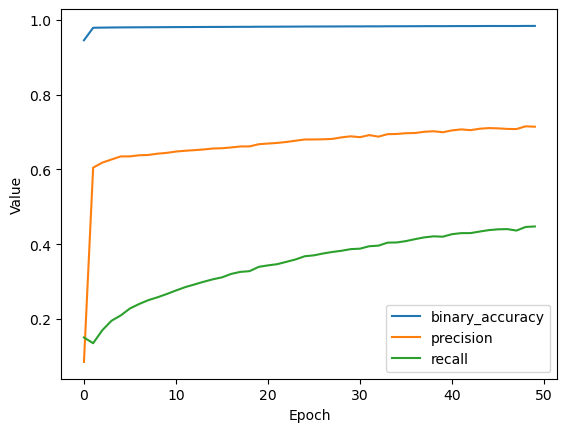

In [20]:
# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['binary_accuracy', 'precision', 'recall', ] # 'f1_score' 

plot_curve(epochs, history_df, list_of_metrics_to_plot)

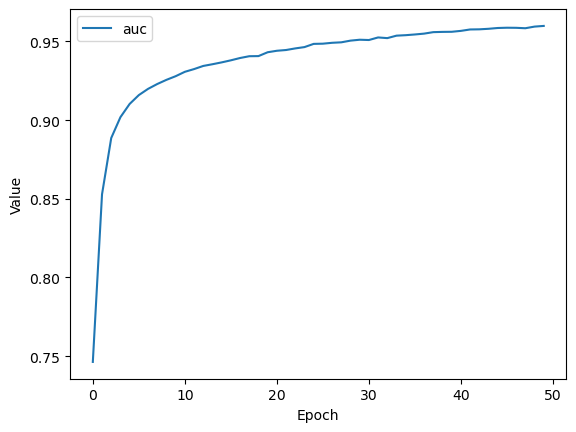

In [21]:
# Plot a graph of the Area under the curve (AUC) of the Receiver Operating Characteristic (ROC) vs. epochs.
list_of_metrics_to_plot = ['auc'] 

plot_curve(epochs, history_df, list_of_metrics_to_plot)

## Submission


For submission we will use the protein embeddings of the test data created by Sergei Fironov using the Rost Lab's T5 protein language model.



In [22]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)


(141865, 1024)


The `test_df` is composed of 1024 columns and 141865 entries. We can see all 1024 dimensions(results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [23]:
test_df.head()


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


Use the model to make predictions on the test embeddings:

In [24]:
predictions =  model.predict(test_df)

4434/4434 [==============================] - 21s 5ms/step


From the predictions we will create the submission dataframe.

Note: This will take at least 15 to 20 minutes to finish.

In [25]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns=['Protein Id', 'GO Term Id', 'Prediction'])
# Create an empty DataFrame 'df_submission' with columns named 'Protein Id', 'GO Term Id', and 'Prediction'.
# The DataFrame will be used to store the submission data.

test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
# Load the test protein IDs from the specified file path using 'np.load()'.

l = []
for k in list(test_protein_ids):
    l += [k] * predictions.shape[1]
# Create a list 'l' that repeats each test protein ID 'predictions.shape[1]' times.
# This is done to match the number of predictions per protein in the 'predictions' array.

df_submission['Protein Id'] = l
# Assign the list 'l' as the values for the 'Protein Id' column in the 'df_submission' DataFrame.

df_submission['GO Term Id'] = labels_to_consider * predictions.shape[0]
# Repeat the 'labels' list 'predictions.shape[0]' times and assign it as the values for the 'GO Term Id' column in 'df_submission'.

df_submission['Prediction'] = predictions.ravel()
# Flatten the 'predictions' array into a 1-dimensional array and assign it as the values for the 'Prediction' column in 'df_submission'.

df_submission.to_csv("submission.tsv", header=False, index=False, sep="\t")
# Save the 'df_submission' DataFrame as a TSV file named "submission.tsv".
# The 'header=False' parameter ensures that the column names are not included in the output file.
# The 'index=False' parameter excludes the index column from the output file.
# The 'sep="\t"' parameter sets the delimiter to a tab character for TSV format.

In [26]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,8.819979e-01
1,Q9CQV8,GO:0008150,6.354282e-01
2,Q9CQV8,GO:0110165,8.946807e-01
3,Q9CQV8,GO:0003674,7.358509e-01
4,Q9CQV8,GO:0005622,7.946850e-01
...,...,...,...
212655630,A0A3G2FQK2,GO:0045861,7.169740e-04
212655631,A0A3G2FQK2,GO:0051783,2.579348e-05
212655632,A0A3G2FQK2,GO:0031674,3.648033e-10
212655633,A0A3G2FQK2,GO:0001818,4.145089e-08
